# Installation


In [ ]:
#install pot package
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 4.5 MB/s eta 0:00:00


In [16]:
#import relevant packages
import pylab as pl
import time
import numpy as np
import ot

import os
from pathlib import Path
from matplotlib import pyplot as plt

# Transporting Eggs from Grocery stores to Restaurants in Seattle


For this example, we assume that grocery stores in Seattle have their own chickens that produce eggs. We aim to find the optimal way in which we can transport eggs from grocery stores to restaurants that use them.

Total eggs : 459


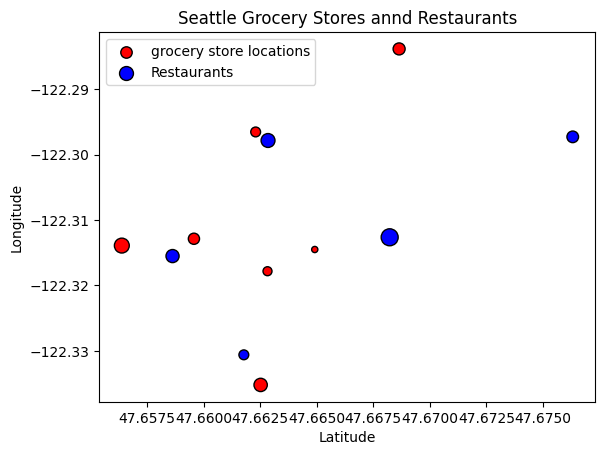

In [26]:
##### creating the dataset. #####

# lat and long of grocery stores in seattle
grocery_store_pos = np.array([[47.662304148389836, -122.2965122479331],
                              [47.662827677445314, -122.31781597756866],
                              [47.66491601325748, -122.31449531742149],
                              [47.6563892286965, -122.31389450260826],
                              [47.668644237339116, -122.28381084660442],
                              [47.659575978060296, -122.31285095228691],
                              [47.66252419977585, -122.33520984640673]])

# how many eggs each store produces in a day
grocery_prod = np.array([50, 42, 20, 115, 75, 65, 92])

#locations of restaurants that need eggs
restaurant_pos = np.array([[47.66285104085316, -122.297818544782],
 [47.668226747623144, -122.312624338393],
 [47.66178161384111, -122.33060586757978],
 [47.65863101217139, -122.31549966649901],
 [47.67631724397799, -122.29726064655853]])

#demand for eggs from restaurants.
restaurant_sales = np.array([100, 150, 50, 89, 70])

#For this example, the number of eggs produced from grocery stores is equal to the total egg demand from restaurants.
print('Total eggs : {}'.format(grocery_prod.sum()))

pl.scatter(grocery_store_pos[:, 0], grocery_store_pos[:, 1], s=grocery_prod, c='r', ec='k', label='grocery store locations')
pl.scatter(restaurant_pos[:, 0], restaurant_pos[:, 1], s=restaurant_sales, c='b', ec='k', label='Restaurants')
pl.xlabel('Latitude')
pl.ylabel('Longitude')
pl.title('Seattle Grocery Stores annd Restaurants')
pl.legend()
pl.show()

In [38]:
#####Using Linear Programming#####
C = ot.dist(grocery_store_pos, restaurant_pos)
start = time.time()
ot_emd = ot.emd(grocery_prod, restaurant_sales, C)
time_emd = time.time() - start
print(time_emd)

0.005888462066650391


<ipython-input-38-82d4489c6f5b>:4: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  ot_emd = ot.emd(grocery_prod, restaurant_sales, C)


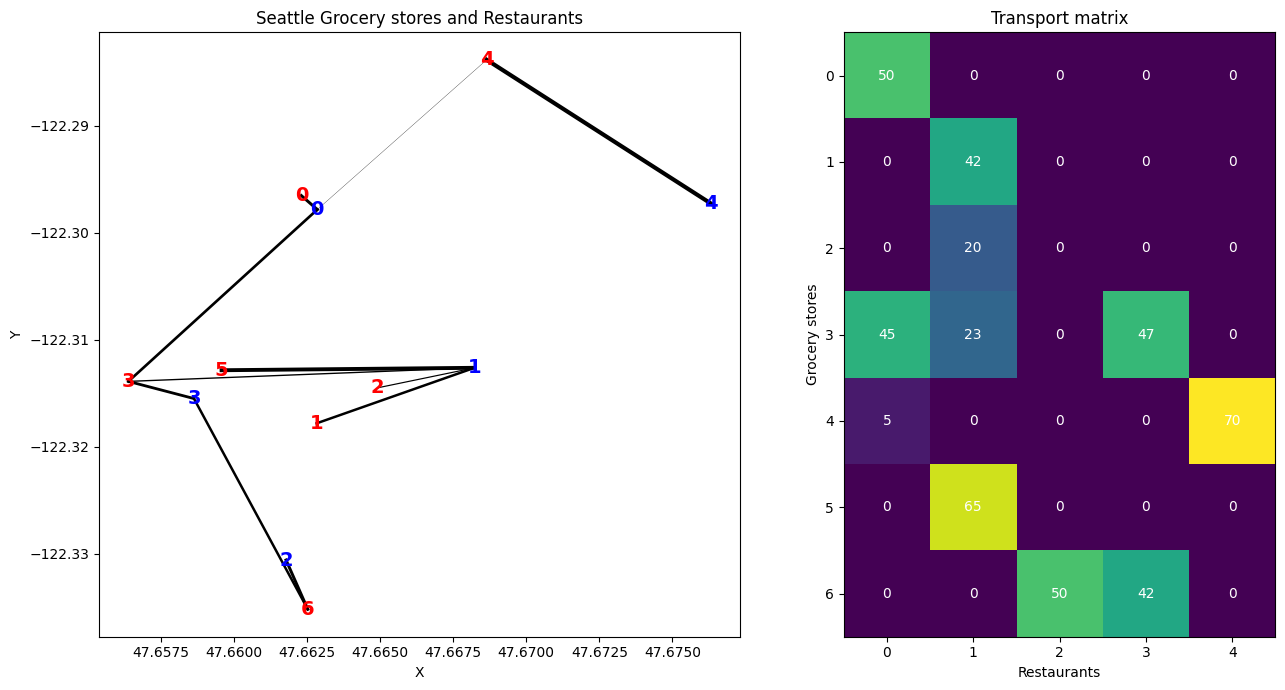

In [28]:
#Plot transport graph and matrix
labels = [str(i) for i in range(len(grocery_prod))]

pl.figure(figsize=(14, 7))
pl.subplot(121)

for i in range(len(grocery_store_pos)):
    for j in range(len(restaurant_pos)):
        pl.plot([grocery_store_pos[i, 0], restaurant_pos[j, 0]], [grocery_store_pos[i, 1], restaurant_pos[j, 1]],
                '-k', lw=3. * ot_emd[i, j] / ot_emd.max())

for i, (x, y) in enumerate(restaurant_pos):
    pl.text(x, y, labels[i], color='b', fontsize=14, fontweight='bold', ha='center', va='center')

for i, (x, y) in enumerate(grocery_store_pos):
    pl.text(x, y, labels[i], color='r', fontsize=14, fontweight='bold', ha='center', va='center')

pl.title('Seattle Grocery stores and Restaurants')
pl.xlabel('X')
pl.ylabel('Y')

pl.subplot(122)
pl.imshow(ot_emd)

for i in range(len(grocery_prod)):
    for j in range(len(restaurant_sales)):
        pl.text(j, i, '{0:g}'.format(ot_emd[i, j]), ha="center", va="center", color="w")

pl.title('Transport matrix')
pl.xlabel('Restaurants')
pl.ylabel('Grocery stores')

pl.tight_layout()
pl.show()


In [29]:
#### Using Sinkhorn Algorithm ####
reg = 0.1
ot_sinkhorn = ot.sinkhorn(grocery_prod, restaurant_sales, reg=reg, M=C / C.max())

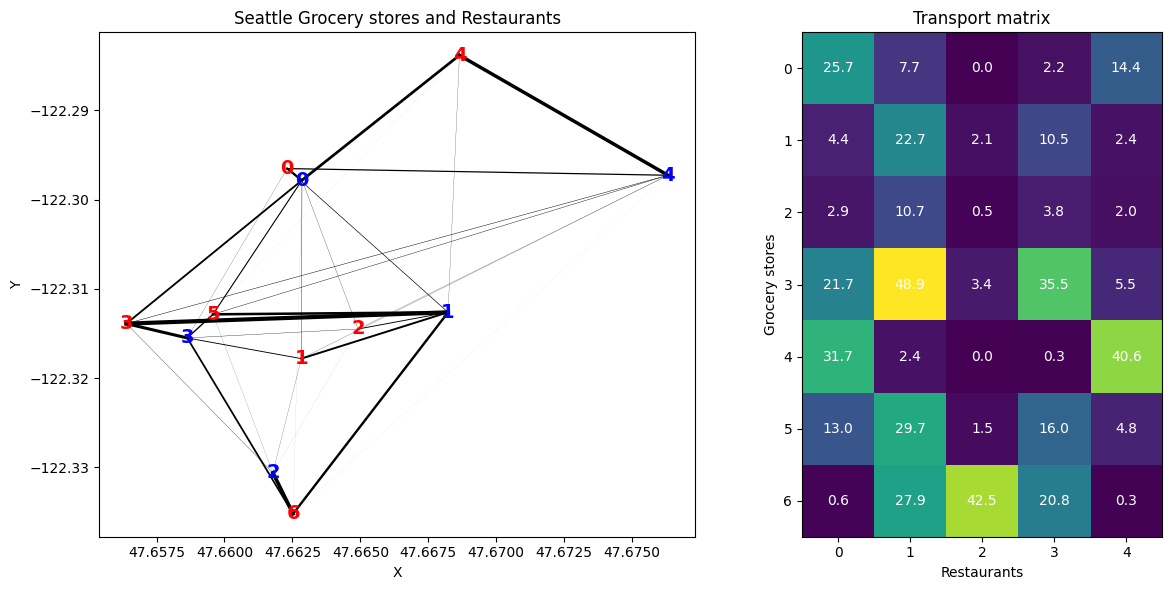

In [30]:
# Plot Sinkhorn transport matrix
pl.figure(figsize=(13, 6))

# Subplot 1
pl.subplot(121)
for i in range(len(grocery_store_pos)):
    for j in range(len(restaurant_pos)):
        pl.plot([grocery_store_pos[i, 0], restaurant_pos[j, 0]],
                [grocery_store_pos[i, 1], restaurant_pos[j, 1]],
                '-k', lw=3. * ot_sinkhorn[i, j] / ot_sinkhorn.max())

for i, (x, y) in enumerate(restaurant_pos):
    pl.text(x, y, labels[i], color='b', fontsize=14, fontweight='bold', ha='center', va='center')

for i, (x, y) in enumerate(grocery_store_pos):
    pl.text(x, y, labels[i], color='r', fontsize=14, fontweight='bold', ha='center', va='center')

pl.title('Seattle Grocery stores and Restaurants')
pl.xlabel('X')
pl.ylabel('Y')

# Subplot 2
ax = pl.subplot(122)
im = pl.imshow(ot_sinkhorn)

for i in range(len(grocery_store_pos)):
    for j in range(len(restaurant_pos)):
        text = ax.text(j, i, np.round(ot_sinkhorn[i, j], 1), ha="center", va="center", color="w")

pl.title('Transport matrix')
pl.xlabel('Restaurants')
pl.ylabel('Grocery stores')

pl.tight_layout()
pl.show()


[0.02222681 0.01347804 0.0123055  0.01074886 0.00957584 0.00964522
 0.00979733 0.00763822 0.00437021 0.00300598 0.00238085 0.00186968
 0.00170732 0.00130033 0.00085449 0.0006156  0.00066233 0.00049162
 0.00037599 0.0003593 ]
0.005888462066650391


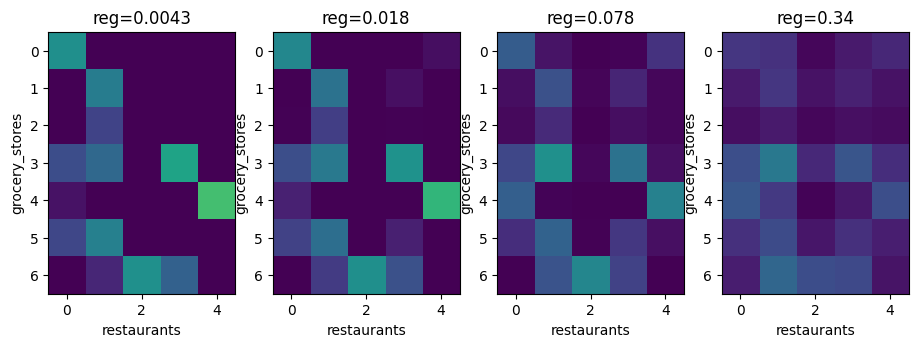

In [39]:
#### The regularisation effect ####
reg_parameter = np.logspace(-3, 0, 20)
W_sinkhorn_reg = np.zeros((len(reg_parameter), ))
time_sinkhorn_reg = np.zeros((len(reg_parameter), ))

f = pl.figure(5, (14, 5))
pl.clf()
max_ot = 100
for k in range(len(reg_parameter)):
    start = time.time()
    ot_sinkhorn = ot.sinkhorn(grocery_prod, restaurant_sales, reg=reg_parameter[k], M=C / C.max())
    time_sinkhorn_reg[k] = time.time() - start

    if k % 4 == 0 and k > 0:
        ax = pl.subplot(1, 5, k // 4)
        im = pl.imshow(ot_sinkhorn, vmin=0, vmax=max_ot)
        pl.title('reg={0:.2g}'.format(reg_parameter[k]))
        pl.xlabel('restaurants')
        pl.ylabel('grocery_stores')
W_sinkhorn_reg[k] = np.sum(ot_sinkhorn * C)

print(time_sinkhorn_reg)
print(time_emd)

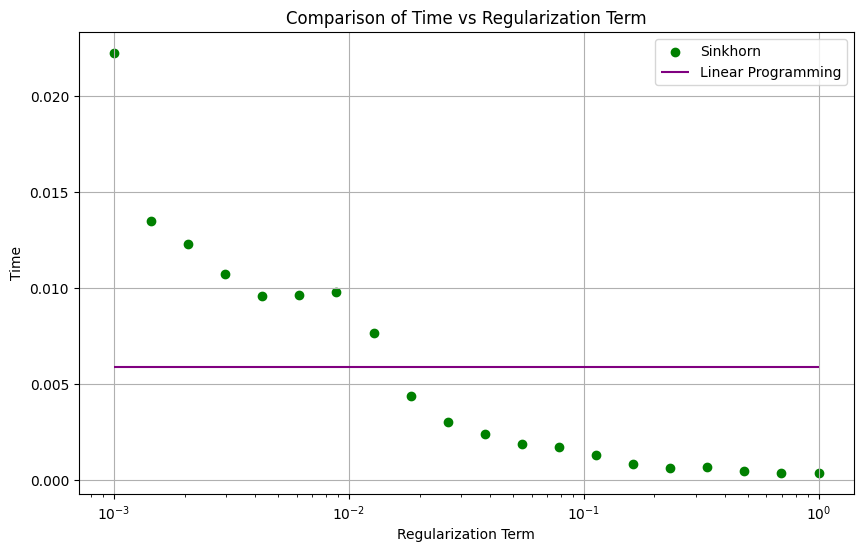

In [43]:
plt.figure(figsize=(10, 6))

# Plot Sinkhorn data
plt.scatter(reg_parameter, time_sinkhorn_reg, label="Sinkhorn", color='green')

# Plot Linear Programming data
plt.hlines(y=time_emd, xmin=min(reg_parameter), xmax=max(reg_parameter),
           label="Linear Programming", color='purple')

# Formatting plot
plt.xscale('log')
plt.xlabel('Regularization Term')
plt.ylabel('Time')
plt.title('Comparison of Time vs Regularization Term')
plt.legend()
plt.grid(True)

plt.show()

# Image processing


For this example, we aim to tranfer colours from two different images with optimal transport


In [ ]:
rng = np.random.RandomState(42)

def im2mat(img):
    """Converts an image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)


def minmax(img):
    return np.clip(img, 0, 1)

In [ ]:
# Loading images
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent.parent.parent, 'data')

I1 = plt.imread(os.path.join(data_path, '/content/scenic-mountains-landscape-after-rain-carpathians-ukraine.jpg')).astype(np.float64) / 256
I2 = plt.imread(os.path.join(data_path, '/content/highland-vegetation-modest-summer-unusually-beautiful-colors-blooms-autumn-before-cold-weather-blueberries-bright-red-coniferous-forest-green-orange-buk-mountains-sinie-fantastic-charm.jpg')).astype(np.float64) / 256

X1 = im2mat(I1)
X2 = im2mat(I2)

# training samples
nb = 500
idx1 = rng.randint(X1.shape[0], size=(nb,))
idx2 = rng.randint(X2.shape[0], size=(nb,))

Xs = X1[idx1, :]
Xt = X2[idx2, :]


In [ ]:
# Linear Programming
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)



transp_Xs_emd = ot_emd.transform(Xs=X1)
transp_Xt_emd = ot_emd.inverse_transform(Xt=X2)

transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=X1)
transp_Xt_sinkhorn = ot_sinkhorn.inverse_transform(Xt=X2)

I1t = minmax(mat2im(transp_Xs_emd, I1.shape))
I2t = minmax(mat2im(transp_Xt_emd, I2.shape))

I1te = minmax(mat2im(transp_Xs_sinkhorn, I1.shape))
I2te = minmax(mat2im(transp_Xt_sinkhorn, I2.shape))

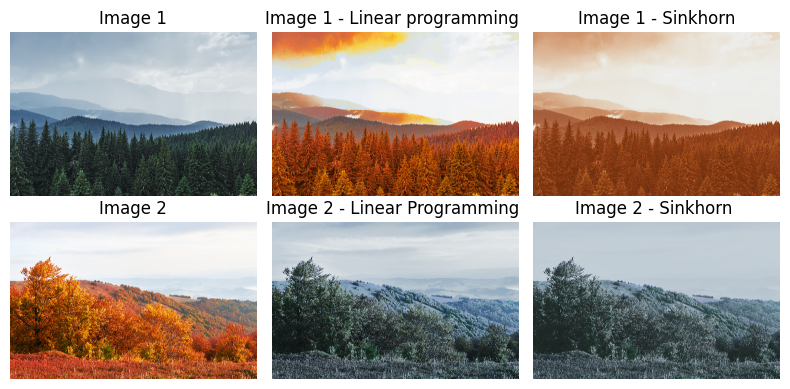

In [ ]:
plt.figure(3, figsize=(8, 4))

plt.subplot(2, 3, 1)
plt.imshow(I1)
plt.axis('off')
plt.title('Image 1')

plt.subplot(2, 3, 2)
plt.imshow(I1t)
plt.axis('off')
plt.title('Image 1 - Linear programming ')

plt.subplot(2, 3, 3)
plt.imshow(I1te)
plt.axis('off')
plt.title('Image 1 - Sinkhorn')

plt.subplot(2, 3, 4)
plt.imshow(I2)
plt.axis('off')
plt.title('Image 2')

plt.subplot(2, 3, 5)
plt.imshow(I2t)
plt.axis('off')
plt.title('Image 2 - Linear Programming ')

plt.subplot(2, 3, 6)
plt.imshow(I2te)
plt.axis('off')
plt.title('Image 2 - Sinkhorn ')
plt.tight_layout()

plt.show()
